In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 発展的なRNNの手法を理解する
KerasのRecurrentレイヤー
- RNN
- SimpleRNN
- GRU
- LSTM
- ConvLSTM2D
- SimpleRNNCell
- GRUCell
- LSTMCell
- StackedRNNCells
- CuDNNGRU
- CuDNNLSTM

## 【問題1】各種手法の実行
Keras公式のサンプルをスタートコードとします。これを元に、上記11個の項目全てを使用してください。

例えばこの中でSimpleRNNとLSTMなどは並列関係であり、精度の比較が行えます。そういった関係を見つけて比較をしてください。

なおConvLSTM2Dのみ2次元配列を受け付ける手法であり、他と単純な精度の比較はできません。

In [2]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
#num_words: 整数 または None． 指定された数値だけ上位の頻出語が対象
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
#デフォルトはぜろを前うめ
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


## LSTM

In [4]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
histry = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 166s 7ms/step - loss: 0.4675 - acc: 0.7749 - val_loss: 0.3750 - val_acc: 0.8375
Epoch 2/4
25000/25000 [==============================] - 164s 7ms/step - loss: 0.3000 - acc: 0.8789 - val_loss: 0.4380 - val_acc: 0.8301
Epoch 3/4
25000/25000 [==============================] - 163s 7ms/step - loss: 0.2156 - acc: 0.9171 - val_loss: 0.4231 - val_acc: 0.8341
Epoch 4/4
25000/25000 [==============================] - 29s 1ms/step
Test score: 0.46929516831874846
Test accuracy: 0.82924


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


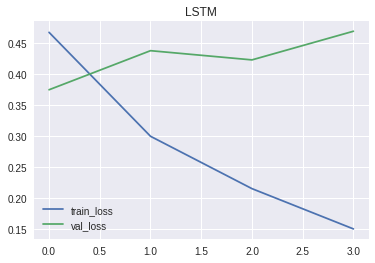

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = histry.history["loss"]
val_loss = histry.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("LSTM")
plt.legend()

## RNN

In [0]:
import keras
import keras.backend as K
class MinimalRNNCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True
    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]

In [22]:
from keras.layers import RNN
print('Build model...')
rnnmodel = Sequential()
cell = MinimalRNNCell(32)
rnnmodel.add(Embedding(max_features, 128))
rnnmodel.add(RNN(cell))
rnnmodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
rnnhist = rnnmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = rnnmodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 33s 1ms/step - loss: 0.4729 - acc: 0.7695 - val_loss: 0.3637 - val_acc: 0.8393
Epoch 2/4
25000/25000 [==============================] - 31s 1ms/step - loss: 0.2871 - acc: 0.8834 - val_loss: 0.3917 - val_acc: 0.8236
Epoch 3/4
25000/25000 [==============================] - 31s 1ms/step - loss: 0.2180 - acc: 0.9119 - val_loss: 0.7296 - val_acc: 0.8159
Epoch 4/4
25000/25000 [==============================] - 29s 1ms/step
Test score: 0.46929516831874846
Test accuracy: 0.82924


## simpleRNN

In [23]:
from keras.layers import SimpleRNN
print('Build model...')
srmodel = Sequential()
srmodel.add(Embedding(max_features, 128))
srmodel.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
srmodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
srmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
srhistry = srmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = srmodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 50s 2ms/step - loss: 0.6892 - acc: 0.5412 - val_loss: 0.6543 - val_acc: 0.5864
Epoch 2/4
25000/25000 [==============================] - 49s 2ms/step - loss: 0.5559 - acc: 0.7108 - val_loss: 0.4906 - val_acc: 0.7696
Epoch 3/4
25000/25000 [==============================] - 49s 2ms/step - loss: 0.4628 - acc: 0.7880 - val_loss: 0.5138 - val_acc: 0.7499
Epoch 4/4
25000/25000 [==============================] - 29s 1ms/step
Test score: 0.46929516831874846
Test accuracy: 0.82924


## GRU

In [28]:
from keras.layers import GRU
print('Build model...')
grumodel = Sequential()
grumodel.add(Embedding(max_features, 128))
grumodel.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
grumodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
grumodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
gruhistry = grumodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = grumodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 135s 5ms/step - loss: 0.4768 - acc: 0.7668 - val_loss: 0.3809 - val_acc: 0.8306
Epoch 2/4
25000/25000 [==============================] - 132s 5ms/step - loss: 0.2925 - acc: 0.8814 - val_loss: 0.3525 - val_acc: 0.8472
Epoch 3/4
25000/25000 [==============================] - 132s 5ms/step - loss: 0.1818 - acc: 0.9310 - val_loss: 0.3980 - val_acc: 0.8388
Epoch 4/4
25000/25000 [==============================] - 23s 918us/step
Test score: 0.5057085846614837
Test accuracy: 0.83056


## SimpleRNNCell

In [48]:
from keras.layers import SimpleRNNCell
print('Build model...')
smcmodel = Sequential()
smcmodel.add(Embedding(max_features, 128))
cell = SimpleRNNCell(128, dropout=0.2, recurrent_dropout=0.2)
smcmodel.add(RNN(cell))
smcmodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
smcmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
smchistry = smcmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = smcmodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 55s 2ms/step - loss: 0.6947 - acc: 0.5306 - val_loss: 0.6666 - val_acc: 0.5879
Epoch 2/4
25000/25000 [==============================] - 51s 2ms/step - loss: 0.5836 - acc: 0.6834 - val_loss: 0.5000 - val_acc: 0.7614
Epoch 3/4
25000/25000 [==============================] - 50s 2ms/step - loss: 0.4868 - acc: 0.7749 - val_loss: 0.5027 - val_acc: 0.7671
Epoch 4/4
25000/25000 [==============================] - 8s 328us/step
Test score: 0.5006974367332458
Test accuracy: 0.77048


StackedRNNCells (多層lstm)

In [31]:
from keras.layers import StackedRNNCells
output_dim = 128
cells = [
    keras.layers.LSTMCell(output_dim),
    keras.layers.LSTMCell(output_dim),
    keras.layers.LSTMCell(output_dim),
]

print('Build model...')
skrmodel = Sequential()
skrmodel.add(Embedding(max_features, 128))
skrmodel.add(RNN(StackedRNNCells(cells)))
skrmodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
skrmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
skrhist = skrmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = skrmodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 359s 14ms/step - loss: 0.4364 - acc: 0.7917 - val_loss: 0.3933 - val_acc: 0.8354
Epoch 2/4
25000/25000 [==============================] - 354s 14ms/step - loss: 0.2631 - acc: 0.8968 - val_loss: 0.3891 - val_acc: 0.8368
Epoch 3/4
25000/25000 [==============================] - 355s 14ms/step - loss: 0.1930 - acc: 0.9272 - val_loss: 0.4906 - val_acc: 0.8113
Epoch 4/4
25000/25000 [==============================] - 70s 3ms/step
Test score: 0.5907433878779411
Test accuracy: 0.82416


## CuDNNGRU

In [34]:
from keras.layers import CuDNNGRU
print('Build model...')
cugrumodel = Sequential()
cugrumodel.add(Embedding(max_features, 128))
cugrumodel.add(CuDNNGRU(128))
cugrumodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
cugrumodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
cugruhistry = cugrumodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = cugrumodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 28s 1ms/step - loss: 0.4372 - acc: 0.7903 - val_loss: 0.3455 - val_acc: 0.8481
Epoch 2/4
25000/25000 [==============================] - 20s 802us/step - loss: 0.2350 - acc: 0.9081 - val_loss: 0.4115 - val_acc: 0.8426
Epoch 3/4
25000/25000 [==============================] - 18s 735us/step - loss: 0.1273 - acc: 0.9548 - val_loss: 0.4366 - val_acc: 0.8288
Epoch 4/4
25000/25000 [==============================] - 5s 203us/step
Test score: 0.6187796028709411
Test accuracy: 0.82656


## CuDNNLSTM

In [35]:
from keras.layers import CuDNNLSTM
print('Build model...')
culstmmodel = Sequential()
culstmmodel.add(Embedding(max_features, 128))
culstmmodel.add(CuDNNLSTM(128))
culstmmodel.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
culstmmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
culsthistry = culstmmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=(x_test, y_test))
score, acc = culstmmodel.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 25s 1ms/step - loss: 0.4347 - acc: 0.7949 - val_loss: 0.3578 - val_acc: 0.8410
Epoch 2/4
25000/25000 [==============================] - 21s 840us/step - loss: 0.2505 - acc: 0.8999 - val_loss: 0.3748 - val_acc: 0.8372
Epoch 3/4
25000/25000 [==============================] - 20s 789us/step - loss: 0.1524 - acc: 0.9428 - val_loss: 0.4667 - val_acc: 0.8116
Epoch 4/4
25000/25000 [==============================] - 5s 201us/step
Test score: 0.5606213924789428
Test accuracy: 0.819


## ConvLSTM2D

Train on 950 samples, validate on 50 samples
Epoch 1/5
950/950 [==============================] - 123s 130ms/step - loss: 0.2109 - val_loss: 0.0890
Epoch 2/5
950/950 [==============================] - 115s 121ms/step - loss: 0.0127 - val_loss: 0.0099
Epoch 3/5
950/950 [==============================] - 115s 121ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 4/5
950/950 [==============================] - 114s 120ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 5/5
950/950 [==============================] - 114s 120ms/step - loss: 9.4599e-04 - val_loss: 9.2523e-04


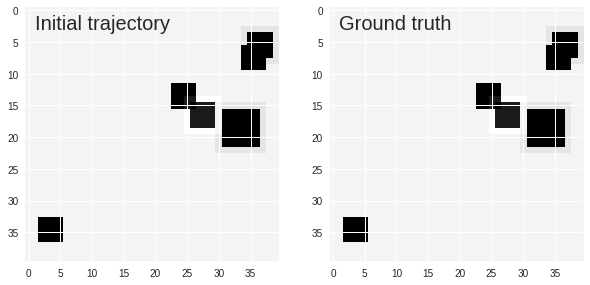

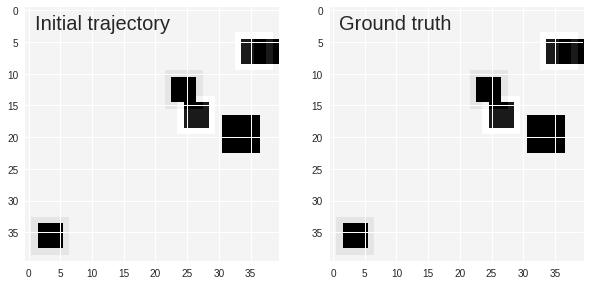

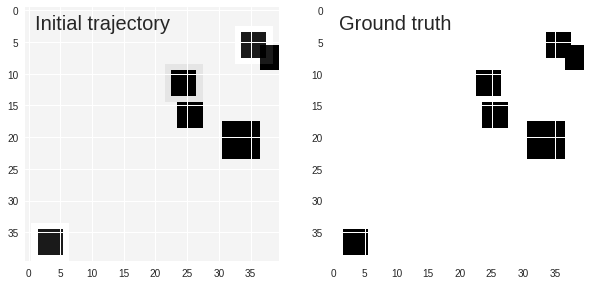

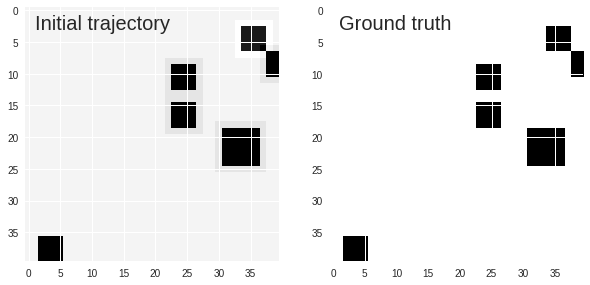

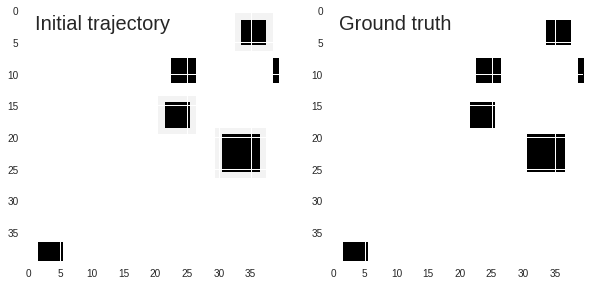

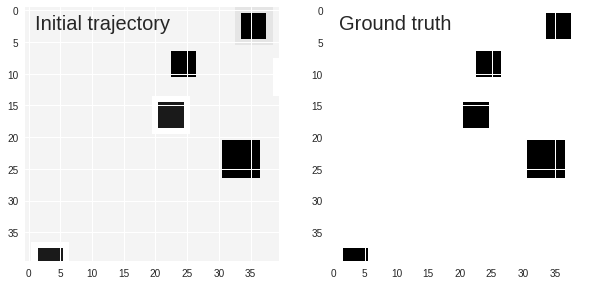

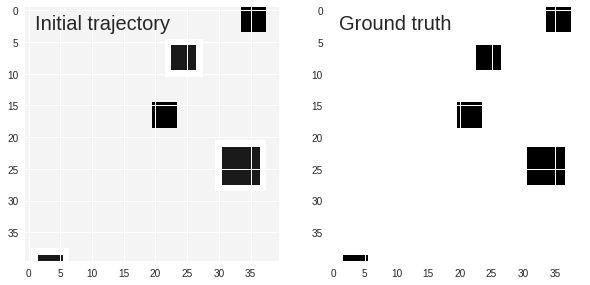

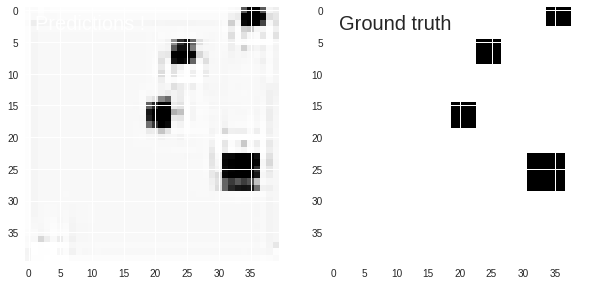

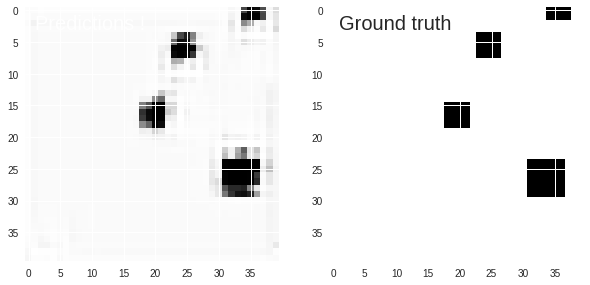

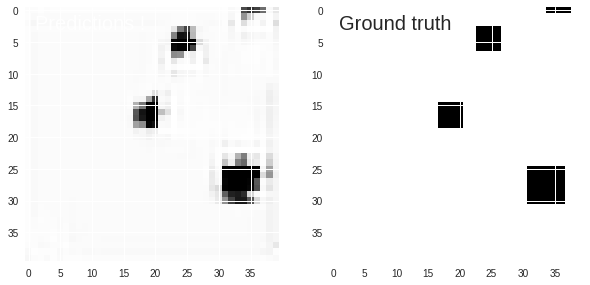

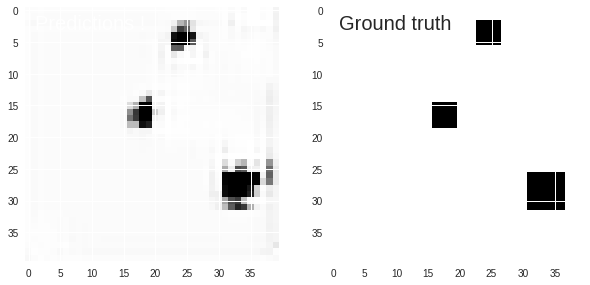

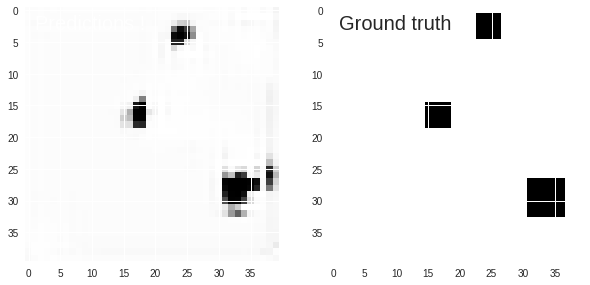

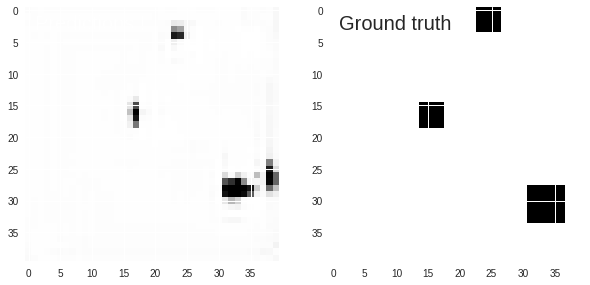

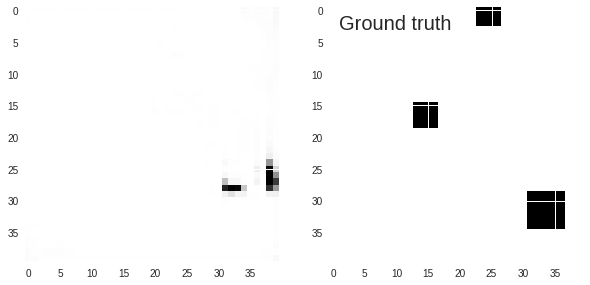

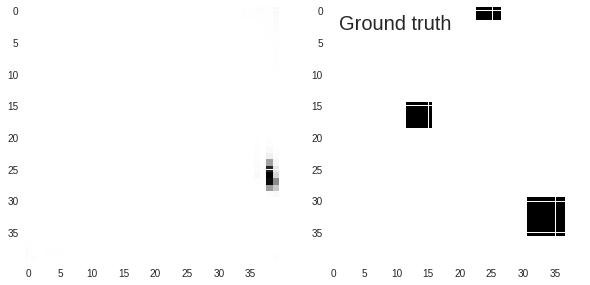

In [36]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=5, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

In [40]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
__________

## 【問題2】比較結果の説明
- RNN

RNNのcellを渡すことで多層RNN、カスタムしたRNNを使うことができる

- SimpleRNN

ベーシックなRNN、処理は一番早いが長いシーケンスになると勾配消滅(爆発)問題がある
- LSTM

処理は時間がかかるが、ゲート、セルで勾配消失の問題を解決したRNN
- GRU

LSTMよりは処理が早い、入力ゲートと忘却ゲートを「更新ゲート」として１つのゲートに統合

- ConvLSTM2D

conv2Dと LSTMを組み合わせたもの　動画などのシーケンスデータを扱うことができる

- CuDNNGRU

GRUをGPU使用するならこちら

- CuDNNLSTM

LSTMをGPU使用するならこちら

In [78]:
#結果表　コラボGPUでやりました
import pandas as pd
lists = [[166, 0.3750, 0.8375],
         [50, 0.4906, 0.7696],
         [135, 0.3525, 0.8472],
         [28, 0.3455 ,0.8481],
          [25, 0.3578, 0.8410]]
         
index = ["LSTM", "simpleRNN", "GRU", "CuDNNGRU", "CuDNNLSTM"]
columns = ["1エポックごとの学習秒数", "val_loss", "val_acc"]
pd.DataFrame(lists, index=index, columns=columns)

,1エポックごとの学習秒数,val_loss,val_acc
LSTM,166,0.3750,0.8375
simpleRNN,50,0.4906,0.7696
GRU,135,0.3525,0.8472
CuDNNGRU,28,0.3455,0.8481
CuDNNLSTM,25,0.3578,0.8410


GPUを使うなら圧倒的にCuDNNGRU, CuDNNLSTMが早い。精度はGRU、LSTMが高い。simpleRNNは精度が低すぎて使う場面はなさそう。総合的にはGRUが軽くて精度も高いので使いやすそう


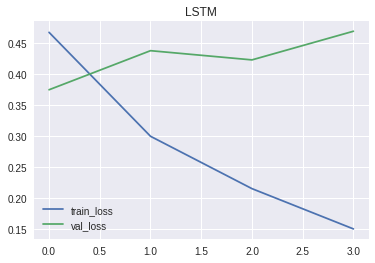

In [41]:
%matplotlib inline

loss = histry.history["loss"]
val_loss = histry.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("LSTM")
plt.legend()

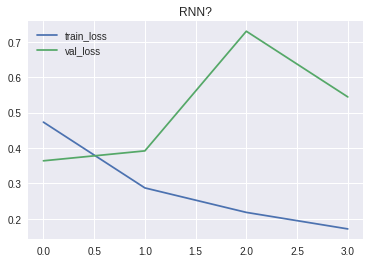

In [52]:
loss = rnnhist.history["loss"]
val_loss = rnnhist.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("RNN?")
plt.legend()

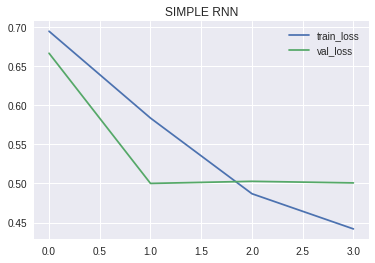

In [55]:
loss = smchistry.history["loss"]
val_loss = smchistry.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("SIMPLE RNN")
plt.legend()

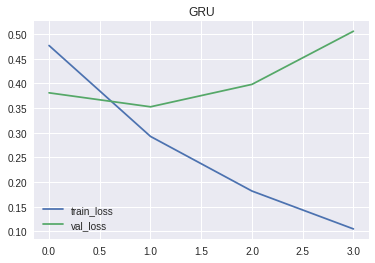

In [56]:
loss = gruhistry.history["loss"]
val_loss = gruhistry.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("GRU")
plt.legend()

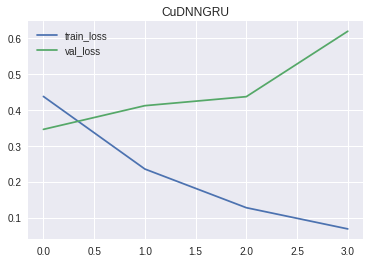

In [57]:
loss = cugruhistry.history["loss"]
val_loss = cugruhistry.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("CuDNNGRU")
plt.legend()

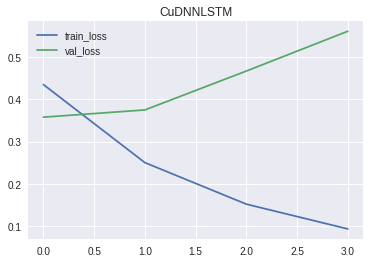

In [58]:
loss = culsthistry.history["loss"]
val_loss = culsthistry.history["val_loss"]

plt.plot(loss , label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("CuDNNLSTM")
plt.legend()